In [1]:
import pandas as pd
import sklearn 
import numpy as np
import matplotlib.pyplot as plt
import json
import keras
from keras import models 
from keras import layers
from keras import regularizers
from keras.utils import np_utils
from numpy.random import seed
seed(1)

%matplotlib inline


Using TensorFlow backend.


In [2]:
df = pd.read_csv("titanic/train.csv")

In [3]:
df.Sex.unique()

array(['male', 'female'], dtype=object)

In [4]:
df['Sex_binary'] = np.where(df['Sex'] == "female", 1, 0)
df.drop(columns='Sex', inplace=True)

In [5]:
# set Embarked_ternary to 1 for C, 2 for Q, 3 for S
df['Embarked_ternary'] = np.where(df["Embarked"] == "C", 1, 
         (np.where(df["Embarked"] == "Q", 2, 3)))

In [6]:
count_nan = len(df['Cabin']) - df['Cabin'].count()

In [7]:
count_nan

687

OK, so most of the Cabin values are NaN, so we can probably drop this column.

In [8]:
df.drop(columns='Cabin', inplace=True)

Not sure about name column, might be useful data in len(name)?

In [9]:
df

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_binary,Embarked_ternary
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,S,0,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C,1,1
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,S,1,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,S,1,3
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,S,0,3
5,6,0,3,"Moran, Mr. James",NaN,0,0,330877,8.4583,Q,0,2
6,7,0,1,"McCarthy, Mr. Timothy J",54.0,0,0,17463,51.8625,S,0,3
7,8,0,3,"Palsson, Master. Gosta Leonard",2.0,3,1,349909,21.0750,S,0,3
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",27.0,0,2,347742,11.1333,S,1,3
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",14.0,1,0,237736,30.0708,C,1,1


In [10]:
# Slightly more likely to survive if younger
df.groupby(['Survived']).Age.mean()

Survived
0    30.626179
1    28.343690
Name: Age, dtype: float64

In [11]:
df.groupby(['Survived']).Fare.mean()

Survived
0    22.117887
1    48.395408
Name: Fare, dtype: float64

In [12]:
# who embarked at Cherbourg?
print("number embarked at Cherbourg", len(df.loc[df['Embarked_ternary'] == 1]))

print("average survival status", df.loc[df['Embarked_ternary'] == 1].Survived.mean())


number embarked at Cherbourg 168
average survival status 0.553571428571


In [13]:
# who embarked at Queenstown?

print("number embarked at Queenstown", len(df.loc[df['Embarked_ternary'] == 2]))

print("average survival status", df.loc[df['Embarked_ternary'] == 2].Survived.mean())


number embarked at Queenstown 77
average survival status 0.38961038961


In [14]:
# who embarked at Southampton?
print("number embarked at Southampton", len(df.loc[df['Embarked_ternary'] == 3]))

print("average survival status", df.loc[df['Embarked_ternary'] == 3].Survived.mean())

number embarked at Southampton 646
average survival status 0.339009287926


OK, so there is some evidence that embarking at Cherbourg is correlated with survival. So let's turn embarkation_ternary into a binary condition: emarbarked_at_cherbourg

In [15]:
df['Embarked_at_cherbourg'] = np.where(df['Embarked_ternary'] == 1, 1, 0)

In [16]:
df.dtypes

PassengerId                int64
Survived                   int64
Pclass                     int64
Name                      object
Age                      float64
SibSp                      int64
Parch                      int64
Ticket                    object
Fare                     float64
Embarked                  object
Sex_binary                 int64
Embarked_ternary           int64
Embarked_at_cherbourg      int64
dtype: object

In [17]:
df.drop(columns="Embarked_ternary", inplace=True)

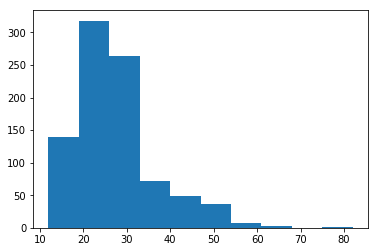

In [18]:
# how do the name lengths vary? And are they correlated with survival?

names_lens = [(name[1], len(name[1])) for name in df["Name"].iteritems()]
name_lens = [name_len[1] for name_len in names_lens]
plt.hist(name_lens)
plt.show()

In [19]:
# add an int value for name length
df['Name_len'] = [len(name[1]) for name in df["Name"].iteritems()]

In [20]:
df.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_binary,Embarked_at_cherbourg,Name_len
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658,-0.042939,-0.001205,-0.012986
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,0.543351,0.168240,0.332350
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,-0.131900,-0.243292,-0.220001
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,-0.093254,0.036261,0.034612
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,0.114631,-0.059528,0.165019
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,0.245489,-0.011069,0.252282
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,0.182333,0.269335,0.155832
Sex_binary,-0.042939,0.543351,-0.131900,-0.093254,0.114631,0.245489,0.182333,1.000000,0.082853,0.448759
Embarked_at_cherbourg,-0.001205,0.168240,-0.243292,0.036261,-0.059528,-0.011069,0.269335,0.082853,1.000000,0.027481
Name_len,-0.012986,0.332350,-0.220001,0.034612,0.165019,0.252282,0.155832,0.448759,0.027481,1.000000


In [21]:
# woah, having a long name is almost as highly correlated with survival as passanger class!

In [22]:
# todo: engineer ticket class
# for now, we'll just drop it

df.drop(columns=['PassengerId', 'Embarked', 'Name', 'Ticket'], inplace=True)

In [23]:
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_binary,Embarked_at_cherbourg,Name_len
0,0,3,22.0,1,0,7.2500,0,0,23
1,1,1,38.0,1,0,71.2833,1,1,51
2,1,3,26.0,0,0,7.9250,1,0,22
3,1,1,35.0,1,0,53.1000,1,0,44
4,0,3,35.0,0,0,8.0500,0,0,24


In [24]:
df.dtypes

Survived                   int64
Pclass                     int64
Age                      float64
SibSp                      int64
Parch                      int64
Fare                     float64
Sex_binary                 int64
Embarked_at_cherbourg      int64
Name_len                   int64
dtype: object

In [25]:
df.isnull().any()

Survived                 False
Pclass                   False
Age                       True
SibSp                    False
Parch                    False
Fare                     False
Sex_binary               False
Embarked_at_cherbourg    False
Name_len                 False
dtype: bool

We have some null ages. Let's see how many.

In [26]:
len(df.loc[df.Age.isnull()])

177

And how are they distributed?

In [27]:
# naively fill nulls for now
df.fillna(df.mean(), inplace=True)

Scale data


In [28]:
df

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_binary,Embarked_at_cherbourg,Name_len
0,0,3,22.000000,1,0,7.2500,0,0,23
1,1,1,38.000000,1,0,71.2833,1,1,51
2,1,3,26.000000,0,0,7.9250,1,0,22
3,1,1,35.000000,1,0,53.1000,1,0,44
4,0,3,35.000000,0,0,8.0500,0,0,24
5,0,3,29.699118,0,0,8.4583,0,0,16
6,0,1,54.000000,0,0,51.8625,0,0,23
7,0,3,2.000000,3,1,21.0750,0,0,30
8,1,3,27.000000,0,2,11.1333,1,0,49
9,1,2,14.000000,1,0,30.0708,1,1,35


In [29]:
(train_passengers, train_labels) = (df.drop('Survived', axis=1), df['Survived'])

In [30]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(train_passengers)
scaler.transform(train_passengers, copy=False)

array([[ 0.82737724, -0.5924806 ,  0.43279337, ..., -0.73769513,
        -0.48204268, -0.42745127],
       [-1.56610693,  0.63878901,  0.43279337, ...,  1.35557354,
         2.0745051 ,  2.59096206],
       [ 0.82737724, -0.2846632 , -0.4745452 , ...,  1.35557354,
        -0.48204268, -0.53525175],
       ..., 
       [ 0.82737724,  0.        ,  0.43279337, ...,  1.35557354,
        -0.48204268,  1.40515682],
       [-1.56610693, -0.2846632 , -0.4745452 , ..., -0.73769513,
         2.0745051 , -0.64305222],
       [ 0.82737724,  0.17706291, -0.4745452 , ..., -0.73769513,
        -0.48204268, -0.85865317]])

In [31]:
# train_passengers is df
train_passengers[train_passengers.columns] = scaler.fit_transform(train_passengers[train_passengers.columns])

In [32]:
# make a function with preceding data-wrangling steps, so that we can perform the same operations on the test set
def wrangle(df):
    """
    takes a df with same format as training set.
    returns df in same format as modified training set
    """
    df['Sex_binary'] = np.where(df['Sex'] == "female", 1, 0)
    df.drop(columns='Sex', inplace=True)
    df['Embarked_ternary'] = np.where(df["Embarked"] == "C", 1, 
         (np.where(df["Embarked"] == "Q", 2, 3)))
    df.drop(columns='Cabin', inplace=True)
    df['Embarked_at_cherbourg'] = np.where(df['Embarked_ternary'] == 1, 1, 0)
    df.drop(columns="Embarked_ternary", inplace=True)
    names_lens = [(name[1], len(name[1])) for name in df["Name"].iteritems()]
    name_lens = [name_len[1] for name_len in names_lens]
    df['Name_len'] = [len(name[1]) for name in df["Name"].iteritems()]    
    df.drop(columns=['PassengerId', 'Embarked', 'Name', 'Ticket'], inplace=True)
    
    # naively fill in nulls for now
    df.fillna(df.mean(), inplace=True)
    return df

In [33]:
# load and transform test data
df_test = pd.read_csv("titanic/test.csv")
df_test = wrangle(df_test)

In [34]:
test_passengers = df_test

In [35]:
test_passengers[test_passengers.columns] = scaler.fit_transform(test_passengers[test_passengers.columns])

In [36]:
train_passengers.shape

(891, 8)

In [37]:
network = models.Sequential()
network.add(layers.Dense(714, activation='relu', input_shape=(8,))) # experiment with different activation functions

keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)
network.add(layers.Dense(714, activation='relu', activity_regularizer=regularizers.l2(0.001) )) # experiment with different activation functions
network.add(layers.Dense(714, activation='relu')) # experiment with different activation functions
network.add(layers.Dropout(0.5))
network.add(layers.Dense(2, activation='softmax'))
network.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy', 'categorical_accuracy'])
network.fit(train_passengers, train_labels, epochs=10, batch_size=8)

#get the highest validation accuracy of the training epochs
categorical_acc = np.amax(network.fit(train_passengers, train_labels, epochs=10, batch_size=8).history['categorical_accuracy'])
print('Best validation acc of epoch:', categorical_acc)
print('DOTSCIENCE_PARAMETERS=' + json.dumps({"regulariser": "l2", "epocs": 10, "batch_size": 8, "regularisation_val": 0.001}))
print('DOTSCIENCE_SUMMARY=' + json.dumps({"accuracy": categorical_acc}))

Epoch 1/10
891/891 [==============================] - 1s 2ms/step - loss: 0.5235 - acc: 0.7957 - categorical_accuracy: 0.6543
Epoch 2/10
891/891 [==============================] - 1s 1ms/step - loss: 0.4795 - acc: 0.8103 - categorical_accuracy: 0.6756
Epoch 3/10
891/891 [==============================] - 1s 1ms/step - loss: 0.4537 - acc: 0.8204 - categorical_accuracy: 0.6790
Epoch 4/10
891/891 [==============================] - 1s 1ms/step - loss: 0.4430 - acc: 0.8272 - categorical_accuracy: 0.6700
Epoch 5/10
891/891 [==============================] - 1s 1ms/step - loss: 0.4457 - acc: 0.8204 - categorical_accuracy: 0.6813
Epoch 6/10
891/891 [==============================] - 1s 1ms/step - loss: 0.4289 - acc: 0.8316 - categorical_accuracy: 0.6723
Epoch 7/10
891/891 [==============================] - 1s 1ms/step - loss: 0.4343 - acc: 0.8272 - categorical_accuracy: 0.6588
Epoch 8/10
891/891 [==============================] - 1s 1ms/step - loss: 0.4335 - acc: 0.8328 - categorical_accuracy:

In [38]:
results = network.predict(test_passengers)

In [39]:
results.shape

(418, 2)

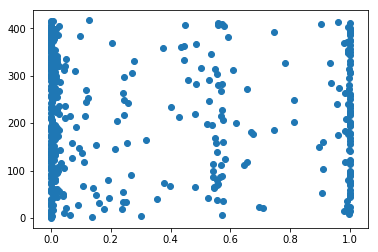

In [40]:
survived = []
for result in results:
    survived.append(result[1])


plt.scatter(survived, range(len(survived)))
plt.show()

In [41]:
# we need binary survival prediction, not a probability
binary_results = network.predict_classes(test_passengers)

In [42]:
# get unwrangled version of test set with the passenger IDs
df_test = pd.read_csv("titanic/test.csv") 

In [43]:
# add column for binary survival status
df_test['Survived'] = binary_results

In [44]:
# write out results
df_test.drop(columns=['Pclass', 'Embarked', 'Name', 'Ticket', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Fare', 'Embarked'], inplace=True)
df_test.to_csv("titanic/predictions.csv", columns = ['PassengerId', 'Survived'])    
df_test.reset_index(drop=True, inplace=True)
